**Urban Data Science Final Project, Spring 2022 - M. Nolan Gray**

Between 2002 and 2013, New York City Department of City Planning (DCP) rezoned roughly a third to half of the borough of Queens. There were two very different types of rezonings: some aiming to stimulate development, most aiming to block or constrain development. In previous research that I have done, I have calculated how each one of these rezonings changed the zoned unit capacity of the borough. For each of these rezonings, DCP also published a City Planning Commission (CPC) report explaining why they are undertaking this rezoning. In this project, I apply the tools of Natural Language Processing to see if we can identify systematic difference in the content and rhetoric of the various rezonings.

In [284]:
import os
import re
from pdfminer.high_level import extract_text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

**Cleaning**

I first tred to scrape the relevant CPC reports (52) directly from DCP's [website](https://a030-cpc.nyc.gov/html/cpc/index.aspx). After playing around with the code for a while, I couldn't make it work, so I manuaully downloaded the reports. Three of these reports continued to throw up issues, so they were removed from the sample, yielding a final sample size of 49. Based on previous analysis I have done on the impact of each rezoning on housing capacity, I code each rezoning as either a downzoning, upzoning, or contextual rezoning.

In the codeblock below, you will find me (a) importing and converting each of these PDFs into txt files and (b) cleaning each of these txt files, which includes (i) removing punctuation, numbers, and various stopwords and otherwise useless words (ii) limiting the text to the CPC public hearing and consideration sections, i.e. the sections where the CPC is "justifying" what it is doing. I create separate lists of word lists for all reports, downzoning reports, upzoning reports, and contextual reports, to faciliate more granular analysis.

In [285]:
def read_and_clean(filename):
    txt = extract_text('cpc_reports/'+filename)
    txt = re.sub(r"[^A-z\s]", "", txt)
    txt = re.sub(r"\s+", " ", txt) 
    txt = txt.split('Commission Public Hearing')[1].split('RESOLUTION RESOLVED')[0]
    txt = txt.lower()
    txt = txt.split()
    swords = stopwords.words('english')
    drop_me = ['january','february','march','april','may','june','july','august','september','october','november',
               'december','city','planning','commission','scheduled','public','hearing','calendar','application',
              'consideration','resolution','zoning','resolved','blocks','block','either','urban','borough','president',
              'floor','area','ratio','comment','comments','eis','eas','feis','project','zone','related','forth','york',
              'types','rezoning','rezonings','subarea','place','places','duly','held','lots','plan','plans','would',
              'first','second','third','fourth','fifth','sixth','seventh','also','one','two','three','four','five',
              'six','seven','eight','nine','ten','speakers','favor','none','opposition','_____________________________________________________________________________________________',
              'street','drive','boulevard','within','opposed','speaker','person','persons','action','included','conjunction',
              'stated','speaking','february','january','continued','original','modified','actions','applications','spoke',
              'alternate','seventeen','voted','queens','borough','amendment','modification','modifications','grand','centra',
              'parkway','several','________________________________________________________________________',
              'testified','support','closed','text','change','explained','supported','overall','proposal','district',
              'herein','hearings','noted','asserted','proposed','believes','believe','developlemt','avenue','notes','areas',
              'along','uses','point','feet','community','board','council','member','councilmember','development','existing']
    txt = [word for word in txt if word not in swords and len(word)>3 and word not in drop_me] 
    return txt

filelist = os.listdir('cpc_reports')
all_reports = [read_and_clean(fn) for fn in filelist if fn.endswith('.pdf')]
downzone_reports = [read_and_clean(fn) for fn in filelist if fn.endswith('D.pdf')]
upzone_reports = [read_and_clean(fn) for fn in filelist if fn.endswith('U.pdf')]
contextual_reports = [read_and_clean(fn) for fn in filelist if fn.endswith('C.pdf')]

**Topic Modeling**

The topic modeling below reveals broadly the two types of zoning that I observed reading the CPC reports myself. There are (1) many downzonings reports concerned with preserving the "character" of neighborhood, deploying terms like "consistent," "appropriate," etc. Terms like "association" help to reveal the important role played by homeowners associations in these rezonings. By constrast, (1) upzoning reports were heavily centered in "commercial" and "industrial" areas, specifically "dutch" "kills," a neighborhood where upzoning activity was heavily concentrated. (The topic modeling output is saved as images [here](https://github.com/mnolangray/random-projects/tree/main/UDS%20Final%20Topic%20Modeling%20Output)!

In [291]:
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
dictionary = gensim.corpora.Dictionary(cpc_reports)
corpus = [dictionary.doc2bow(wl) for wl in cpc_reports]
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=2, alpha = 0.25, eta=0.75)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

/Users/mnolangray/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
0      0.00291  0.0       1        1  68.922277
1     -0.00291  0.0       2        1  31.077723, topic_info=             Term        Freq       Total Category  logprob  loglift
421       housing  167.000000  167.000000  Default  30.0000  30.0000
750   residential  145.000000  145.000000  Default  29.0000  29.0000
2306        dutch   20.000000   20.000000  Default  28.0000  28.0000
2328        kills   20.000000   20.000000  Default  27.0000  27.0000
163    commercial  133.000000  133.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
316        ensure   18.051082   66.661936   Topic2  -5.6822  -0.1377
1045     detached   18.669938   79.105232   Topic2  -5.6485  -0.2752
193    consistent   18.209790   75.471741   Topic2  -5.6734  -0.2531
1077    twofamily   17.950601   72.683892   Topic2  -5.6878  -0.2298
1098        homes   16.621493   68.693310   Topic2  -5.7647  -0.2503

[182 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
35        1  0.667795  affordable
35        2  0.333898  affordable
1035      1  0.784953      albans
1035      2  0.261651      albans
46        1  0.676516       allow
...     ...       ...         ...
896       2  0.312774       units
2364      1  0.538283     waivers
2364      2  0.538283     waivers
929       1  0.705325  waterfront
929       2  0.289364  waterfront

[254 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

/Users/mnolangray/opt/anaconda3/envs/uds/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mnolangray/opt/anaconda3/envs/uds/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mnolangray/opt/anaconda3/envs/uds/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mnolangray/opt/anaconda3/envs/uds/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mnolangray/op

**Word Cloud**

This topic analysis was interesting, but I wanted to produce graphics that could potentially be used in a final paper. To do this, I created wordclouds for the four categories of reports. This again reveals differences in the issues at play: downzones and contextual rezonings (conceptually not far apart) are deeply concerned with character, residential neighborhoods, and subtle distinctions like "twofamily" versus "singlefamily." (Many of those rezonings were explicitly designed to block duplexes in otherwise single-family neighborhoods.) By contrast, upzones use terms like "provide,"  "affordable housing," and "maximum," denoting a very different set of concerns, i.e. the parameters for commercial and industrial areas slated for much more development.

In [287]:
def list_string(list_of_reports):
    reports_merged = [' '.join(report) for report in list_of_reports]
    str1 = " " 
    return (str1.join(reports_merged))
    
all_reports_string = list_string(all_reports)
downzone_reports_string = list_string(downzone_reports)
upzone_reports_string = list_string(upzone_reports)
contextual_reports_string = list_string(contextual_reports)

All Reports


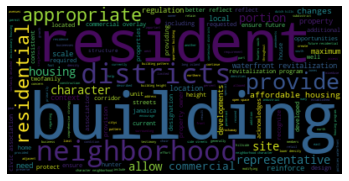

Downzones


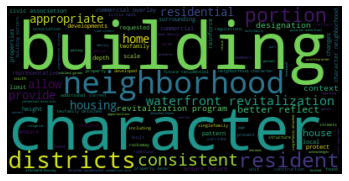

Upzones


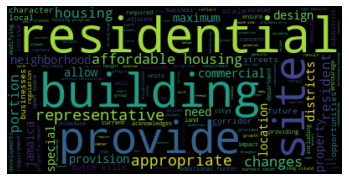

Contextual Rezones


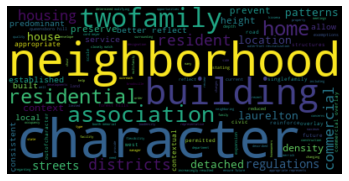

In [337]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud(cpc_string):
    wordcloud = WordCloud().generate(cpc_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
print("All Reports")
wordcloud(all_reports_string)
print("Downzones")
wordcloud(downzone_reports_string)
print("Upzones")
wordcloud(upzone_reports_string)
print("Contextual Rezones")
wordcloud(contextual_reports_string)


**Sentiment Analysis**

Finally, I was curious to see if sentiment varied among downzoning and upzoning rezonings. Is the framing of certain types of rezonings systematically more positive or negative? I test for this below. (I didn't have much reason to believe that they varied on subjectivity and so didn't test for it.)  

As you might expect from CPC reports, there isn't much sentiment either way. (Having written my fair share of these at NYC DCP, I can tell you that they don't exactly invite or inspire colorful prose!) Surprisingly, downzoning reports seem to be more positive than upzoning reports. Perhaps it's the positive qualities of the existing neighborhoods and terms like "protect" that are triggering this? The upzoning reforms seem to be consistently neutral. The sample size for contextual rezonings was too small to be revealing either way.

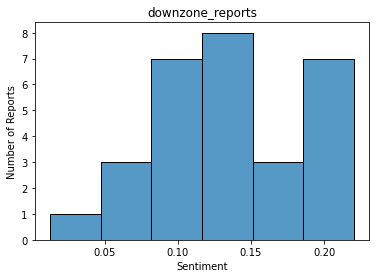

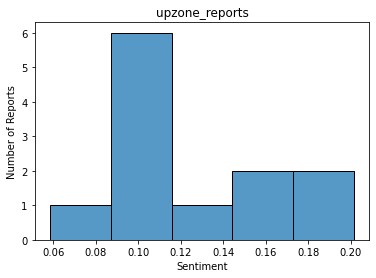

In [338]:
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

def get_and_plot_sentiment(list_of_reports):
    def get_sentiment(report):
        joined_reports = TextBlob(' '.join(report))
        polarity = joined_reports.sentiment.polarity
        return polarity
    sentiment_scores = []
    for report in list_of_reports:
        sentiment_scores.append(get_sentiment(report))
    fig, ax = plt.subplots(sharex=True)
    sns.histplot(sentiment_scores, ax=ax)
    name = str(list_of_reports)
    name = ''.join([name for name in globals() if globals()[name] is list_of_reports])
    ax.set_title('{}'.format(name))
    ax.set_ylabel('Number of Reports')
    ax.set_xlabel('Sentiment')

get_and_plot_sentiment(downzone_reports)
get_and_plot_sentiment(upzone_reports)

**Exporting for Further Analysis**

As part of this project, I'm working with a friend who is a computational linguist to further analyze this data. Below, I export the data. You can ignore it!

In [ ]:
### Exporting data to share and collaborate—ignore me!

#def txty1(filename):
#    txt = extract_text('cpc_reports/'+filename)
#    txt = txt.split('Commission Public Hearing')[1].split('RESOLVED')[0]
#    text_file = open('{}.txt'.format(filename), 'w')
#    text_file.write(txt)
#    text_file.close()
#    return txt
# 
#txt_time = [txty1(fn) for fn in filelist if fn.endswith('.pdf')]

#with open('list_of_lists.txt', 'w') as f:
#    for item in cpc_reports:
#        f.write("%s\n" % item)
#        
#drop_me = ['january','february','march','april','may','june','july','august','september','october','november',
#               'december','city','planning','commission','scheduled','public','hearing','calendar','application',
#              'consideration','resolution','zoning','resolved','blocks','block','either','urban','borough','president',
#              'floor','area','ratio','comment','comments','eis','eas','feis','project','zone','related','forth','york',
#              'types','rezoning','rezonings','subarea','place','places','duly','held','lots','plan','plans','would',
#              'first','second','third','fourth','fifth','sixth','seventh','also','one','two','three','four','five',
#              'six','seven','eight','nine','ten','speakers','favor','none','opposition','_____________________________________________________________________________________________',
#              'street','drive','boulevard','within','opposed','speaker','person','persons','action','included','conjunction',
#              'stated','speaking','february','january','continued','original','modified','actions','applications','spoke',
#              'alternate','seventeen','voted','queens','borough','amendment','modification','modifications','grand','centra',
#              'parkway','several','________________________________________________________________________',
#              'testified','support','closed','text','change','explained','supported','overall','proposal','district',
#              'herein','hearings','noted','asserted','proposed','believes','believe','developlemt','avenue','notes','areas',
#              'along','uses','point','feet','community','board','council','member','councilmember','development','existing']

#with open('list_of_drop_words.txt', 'w') as k:
#    for item in drop_me:
#        k.write("%s\n" % item)

**Conclusions and Next Steps**

It's clear from this highly preliminary analysis that there are, at a minumum, two very different ways that the CPC characterized rezonings during this period. Downzonings talk of preserving character; upzonings talk of unlocking opportunities for affordable housing. 

This is hardly the end of the analysis. I had hoped to include it in this final project, but I am working with the above-mentioned computational linguist friend to study lexical choices and run the text through a transformer. This will allow us to, among other things, classify the documents in more sophisticated ways. This sample size may be too small, but I'm optimistic about what we will find!